# Bathymetry

A simple example to show how to plot the model bathymetry for ACCESS-OM2 configurations.

In [1]:
import intake
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs
from dask.distributed import Client

Start dask cluster:

In [2]:
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 15.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33879,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 15.00 GiB
Comm: tcp://127.0.0.1:43619,Total threads: 1
Dashboard: /proxy/44473/status,Memory: 3.75 GiB
Nanny: tcp://127.0.0.1:36691,


In [3]:
catalog = intake.cat.access_nri

First load the bathymetry for your experiment. 'ht' is on the t grid. If you want bathymetry on the u grid, use 'hu' instead.

In [4]:
experiment = "01deg_jra55v140_iaf_cycle3"  # or, e.g., '1deg_jra55_iaf_omip2_cycle6' or '025deg_jra55_iaf_omip2_cycle6'

var_search = catalog[experiment].search(variable="ht")
ds = var_search.search(
    path=var_search.df.path[0] # we only need one file as bathymetry doesn't change
).to_dask()  
bathymetry = ds["ht"].load()

Load latitude / longitude data for plotting. We can't just load `geolon_t` and `geolat_t` from this experiment, because those variables have land masks which don't work with plotting. Make sure the grid file here matches the resolution of the experiment you are looking at. i.e. Use `ocean_grid_10.nc` if your experiment is 1° or `ocean_grid_025.nc` for 0.25°.

In [5]:
grid = xr.open_dataset("/g/data/ik11/grids/ocean_grid_01.nc")
geolon_t = grid.geolon_t
geolat_t = grid.geolat_t

Create a land mask for plotting, set land cells to 1 and rest to NaN. This is preferred over `cartopy.feature`, because the land that `cartopy.feature` provides differs from the model's land mask.

In [6]:
land = xr.where(np.isnan(bathymetry.rename("land")), 1, np.nan)

And now plot!

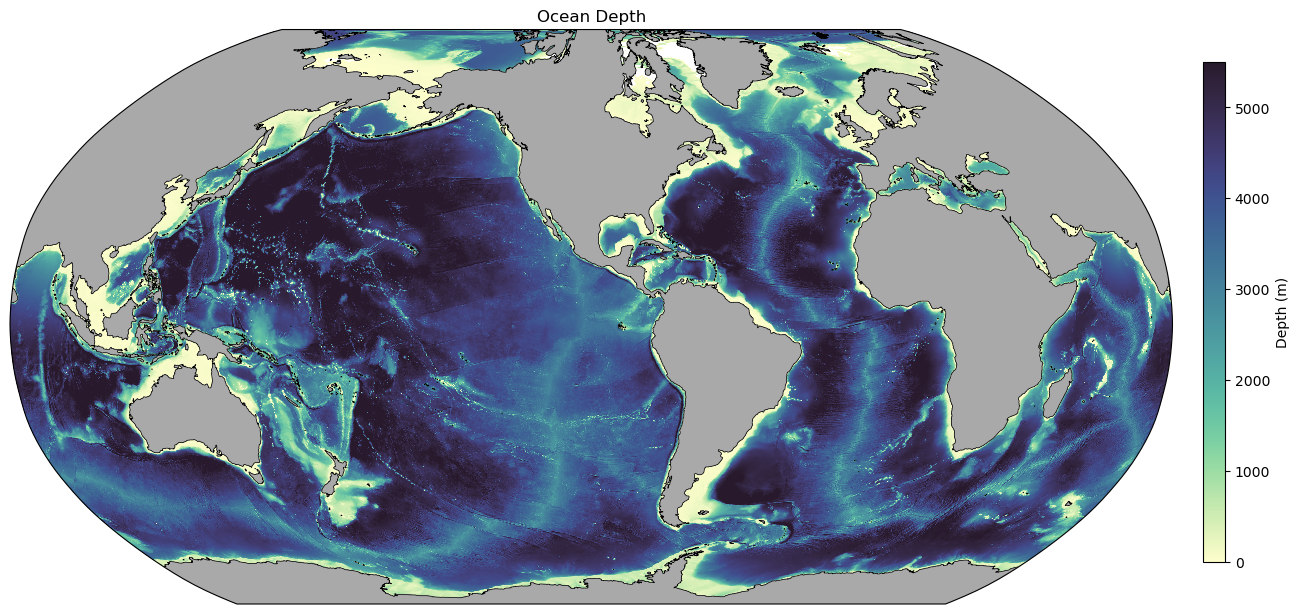

In [7]:
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-100))

# Add model land mask
land.plot.contourf(
    ax=ax, colors="darkgrey", zorder=2, transform=ccrs.PlateCarree(), add_colorbar=False
)
# Add model coastline
land.fillna(0).plot.contour(
    ax=ax,
    colors="k",
    levels=[0, 1],
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
    linewidths=0.5,
)
# Plot bathymetry
p1 = ax.pcolormesh(
    geolon_t,
    geolat_t,
    bathymetry,
    transform=ccrs.PlateCarree(),
    cmap=cm.cm.deep,
    vmin=0,
    vmax=5500,
)

plt.title("Ocean Depth")

ax_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
cb = plt.colorbar(p1, cax=ax_cb, orientation="vertical")
cb.ax.set_ylabel("Depth (m)");

Now let's add pretty land (NASA Blue Marble):

In [8]:
map_path = "/g/data/ik11/grids/BlueMarble.tiff"
blue_marble = plt.imread(map_path)
blue_marble_extent = (-180, 180, -90, 90)

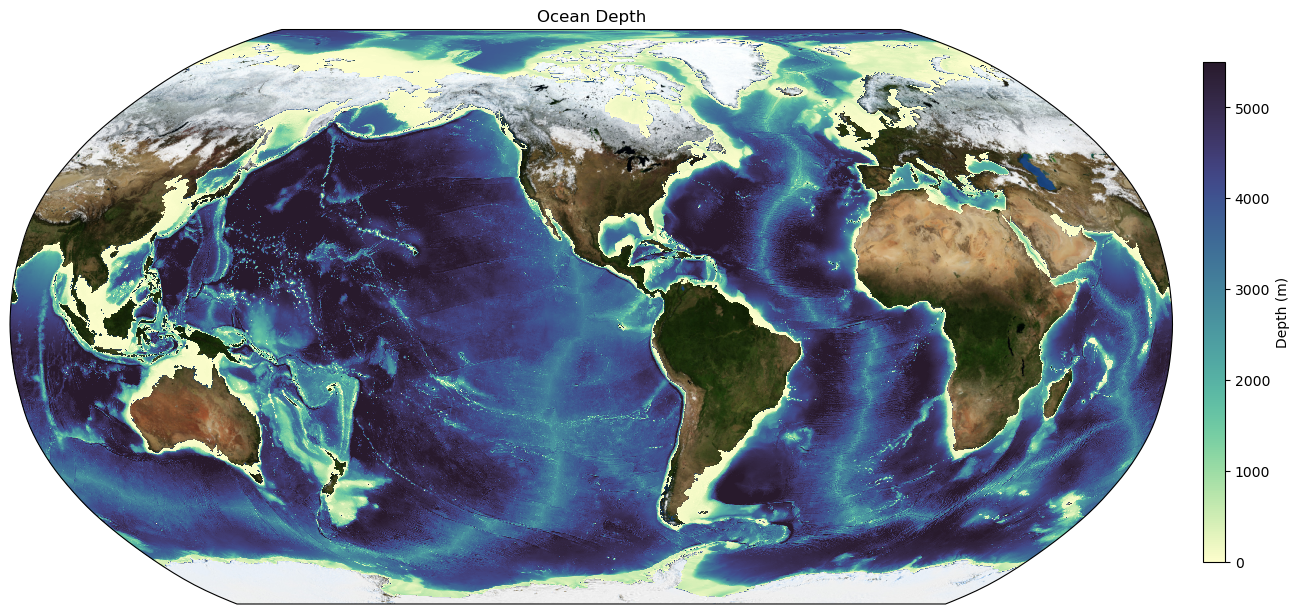

In [9]:
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-100))

# Plot bathymetry
p1 = ax.pcolormesh(
    geolon_t,
    geolat_t,
    bathymetry,
    transform=ccrs.PlateCarree(),
    cmap=cm.cm.deep,
    vmin=0,
    vmax=5500,
)
plt.title("Ocean Depth")

# Add pretty land:
ax.imshow(
    blue_marble, extent=blue_marble_extent, transform=ccrs.PlateCarree(), origin="upper"
)

# Colorbar:
ax_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
cb = plt.colorbar(p1, cax=ax_cb, orientation="vertical")
cb.ax.set_ylabel("Depth (m)");

In [10]:
client.close()